# Implementing all forms of TD with the randomwalk env:

In [1]:
import warnings ; warnings.filterwarnings('ignore')

import gym ,gym_aima, gym_walk
import numpy as np
from pprint import pprint
from tqdm import tqdm_notebook as tqdm
import tabulate

from itertools import cycle, count
import itertools
import tabulate
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)


### All essentials we'll need:

In [2]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    prev_V = np.zeros(len(P), dtype=np.float64)
    while True:
        V = np.zeros(len(P), dtype=np.float64)
        for s in range(len(P)):
            for prob, next_state, reward, done in P[s][pi(s)]:
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        if np.max(np.abs(prev_V - V)) < theta:
            break
        prev_V = V.copy()
    return V

def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")



def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'er')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))



def probability_success(env, pi, goal_state, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        while not done and steps < max_steps:
            state, _, done, h = env.step(pi(state))
            steps += 1
        results.append(state == goal_state)
    return np.sum(results)/len(results)*100

def mean_return(env, gamma, pi, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        results.append(0.0)
        while not done and steps < max_steps:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += (gamma**steps * reward)
            steps += 1
    return np.mean(results)


def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

### Plotting everything:

In [3]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

def plot_targets(targets, init_state, title):
    x = range(len(targets[init_state]))
    y = targets[init_state]
    
    label = 'v({})'.format(init_state)
    plt.axhline(y=V_true[init_state], color='k', linestyle='-', linewidth=1)
    plt.text(int(x[-1]*1.02), V_true[init_state]+.01, label)

    plt.scatter(x, y, 
                c=np.array(targets[init_state]),
                cmap=plt.get_cmap('viridis'),
                alpha=0.4)
    plt.title(title)

    plt.ylabel('Target value')
    plt.xlabel('Estimate sequence number')
    plt.show()

def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

### Our evironment (openai gym)

In [4]:
env=gym.make('RandomWalk-v0')
init_state=env.reset()  #initial state 
goal_state=6 #right most
gamma=1 #setting discount to 1 right now in the beggining only
n_episodes=500
P=env.env.P #represents the transition probabilities of the environment

#env.render() #shows the current state of the agent
#env.observation_space.sample()

/home/anushtup/Documents/Coding/RL/rl/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/anushtup/Documents/Coding/RL/rl/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
LEFT, RIGHT = range(2)
pi = lambda s: {
    0:LEFT, 1:LEFT, 2:LEFT, 3:LEFT, 4:LEFT, 5:LEFT, 6:LEFT
}[s]   #generating a list with all the states

V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P, n_cols=7)
print()
print_policy(pi, P, action_symbols=('<', '>'), n_cols=7)

State-value function:
|           | 01  0.167 | 02  0.333 | 03    0.5 | 04  0.667 | 05  0.833 |           |

Policy:
|           | 01      < | 02      < | 03      < | 04      < | 05      < |           |


In [6]:
def generate_trajectory(pi, env, max_steps=200):
    done=False
    trajectory=[]

    while not done:
        state=env.reset()
        for t in count():
            action=pi(state)
            next_state,reward, done, _=env.step()
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t>=max_steps-1:
                trajectory=[]  #basically stopping at very very long trajectories (truncating them)
                break
            state=next_state
    return np.array(trajectory, np.object)

### TD:

In [10]:
def td(pi, env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5, n_episodes=500):  # we'll be exponentially decaying alpha, helps converge the learning rate (according to the book)
    nS=env.observation_space.n  #n is the number of observations allowed in the observation space (decided by us here)
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    targets = {state:[] for state in range(nS)}
    alphas = decay_schedule(          #learning rate schedule for all the episodes (in case of MC)
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, info= env.step(action) 
            td_target = reward + gamma * V[next_state] * (not done)
            targets[state].append(td_target)
            td_error = td_target - V[state]
            V[state] = V[state] + alphas[e] * td_error
            state = next_state
        V_track[e] = V
    return V, V_track, targets

In [13]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed)
    #env.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds



/tmp/ipykernel_8754/2397965480.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for seed in tqdm(SEEDS, desc='All seeds', leave=True):


All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
print_state_value_function(V_td, P, n_cols=7)
print()
print_state_value_function(V_td - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
|           | 01  0.157 | 02  0.319 | 03   0.49 | 04  0.657 | 05  0.829 |           |

State-value function errors:
|           | 01  -0.01 | 02 -0.015 | 03  -0.01 | 04  -0.01 | 05 -0.004 |           |
RMSE: 0.0086


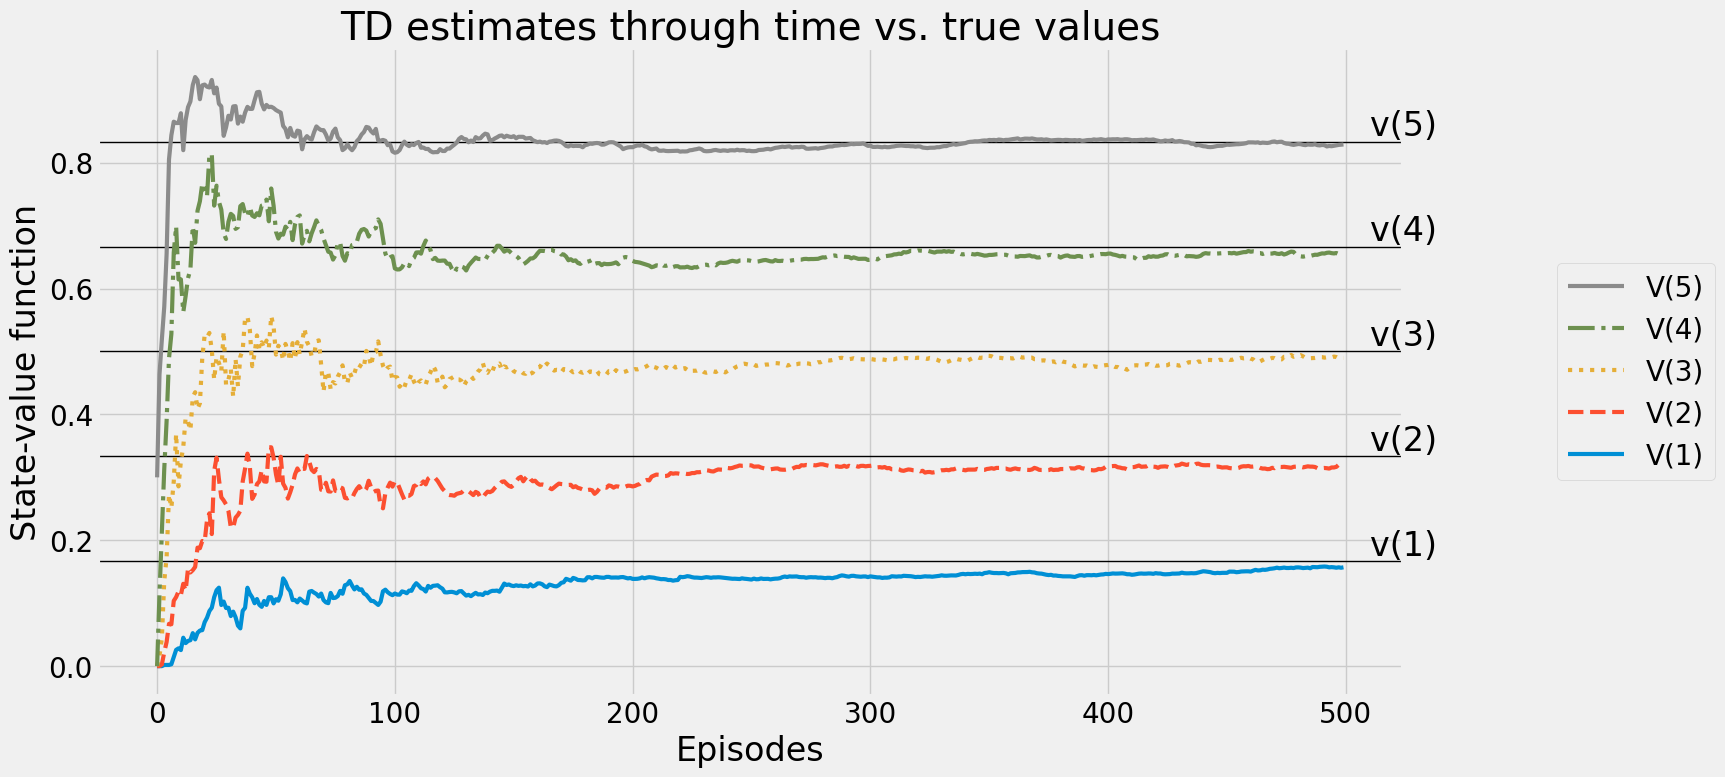

In [15]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

### TD(n):

In [ ]:
def ntd(pi, 
        env, 
        gamma=1.0,
        init_alpha=0.5,
        min_alpha=0.01,
        alpha_decay_ratio=0.5,
        n_step=3,
        n_episodes=500):

    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    discounts = np.logspace(0, n_step+1, num=n_step+1, base=gamma, endpoint=False) #we go for n steps in an evenly distributed logarithmic distribution

    alphas = decay_schedule(
        init_alpha, min_alpha, 
        alpha_decay_ratio, n_episodes)

    for e in tqdm(range(n_episodes), leave=False):  #looping 
        state, done, path = env.reset(), False, []  #path holds the partial trajectory
        while not done or path is not None:
            path = path[1:] #popping the first element of the path
            while not done and len(path) < n_step:
                action = pi(state)
                next_state, reward, done, _ = env.step(action)  #remember that the next state is actually the observation space
                experience = (state, reward, next_state, done)  #accuumulating/keeping track untill the length of the path is equal to the step we set it to be.
                path.append(experience)
                state = next_state
                if done:
                    break

            n = len(path)
            est_state = path[0][0]  #taking the state that we 're estimating (not the actual one)
            rewards = np.array(path)[:,1]  # vector of all rewards encountered from the estimated state to n
            partial_return = discounts[:n] * rewards   #discounted rewards till n
            bs_val = discounts[-1] * V[next_state] * (not done)   #bootstrap (TD)
            ntd_target = np.sum(np.append(partial_return, bs_val))   #summing them 
            ntd_error = ntd_target - V[est_state]
            V[est_state] = V[est_state] + alphas[e] * ntd_error
            if len(path) == 1 and path[0][3]:
                path = None

        V_track[e] = V
    return V, V_track

In [16]:
def td_lambda(pi, 
              env, 
              gamma=1.0,
              init_alpha=0.5,
              min_alpha=0.01,
              alpha_decay_ratio=0.5,
              lambda_=0.3,
              n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    E = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    alphas = decay_schedule(
        init_alpha, min_alpha, 
        alpha_decay_ratio, n_episodes)
    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            E[state] = E[state] + 1
            V = V + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            state = next_state
        V_track[e] = V
    return V, V_track

In [18]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)

/tmp/ipykernel_8754/3605466797.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for seed in tqdm(SEEDS, desc='All seeds', leave=True):


All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

State-value function:
|           | 01  0.176 | 02  0.335 | 03  0.504 | 04  0.681 | 05  0.842 |           |

State-value function errors:
|           | 01  0.009 | 02  0.002 | 03  0.004 | 04  0.014 | 05  0.008 |           |
RMSE: 0.0073


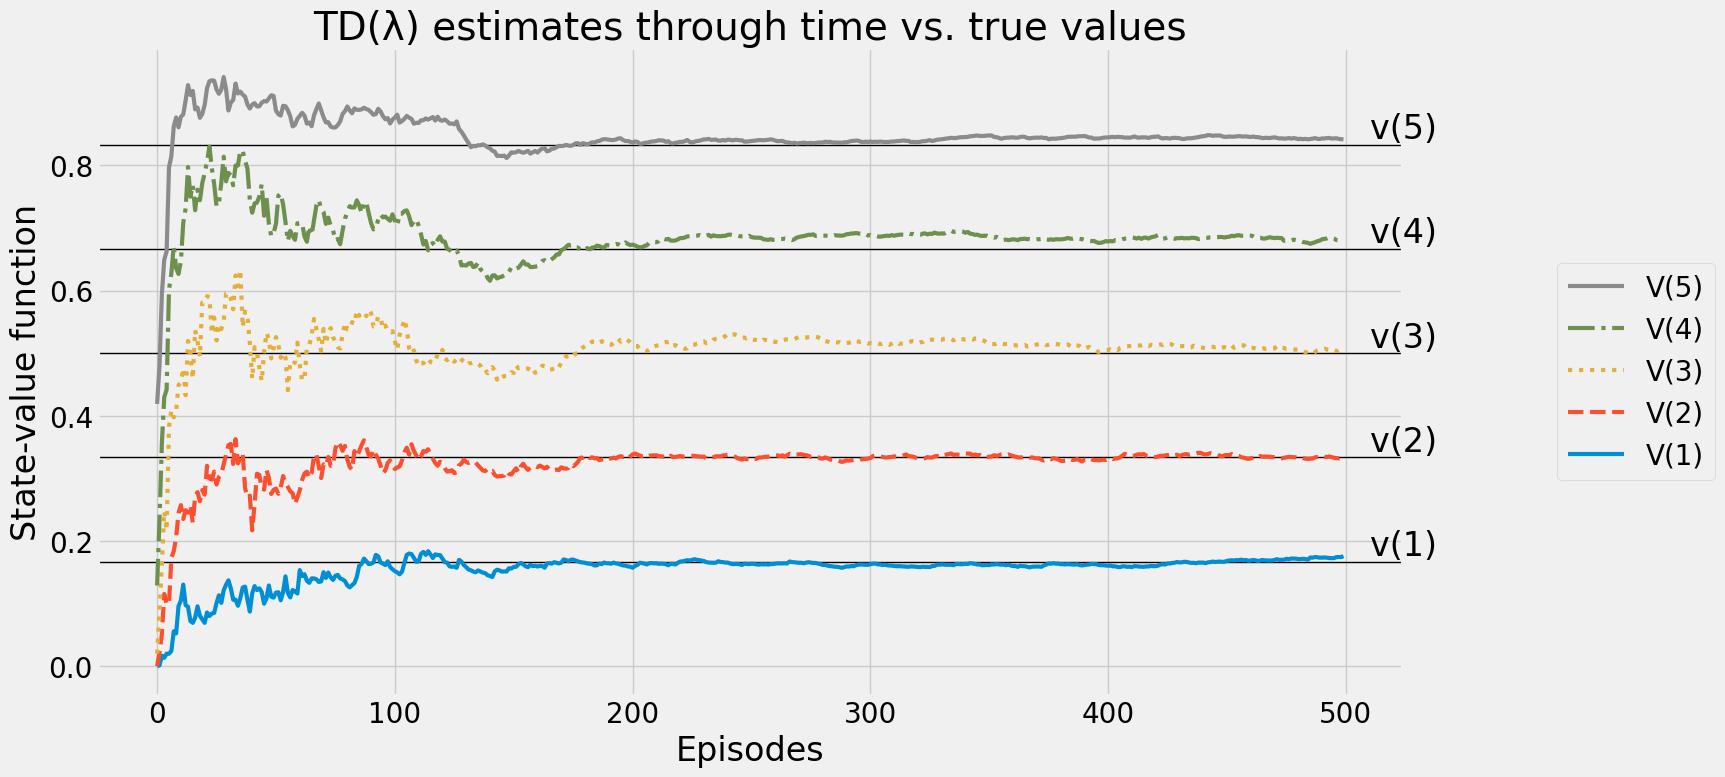

In [19]:


print_state_value_function(V_tdl, P, n_cols=7)
print()
print_state_value_function(V_tdl - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)


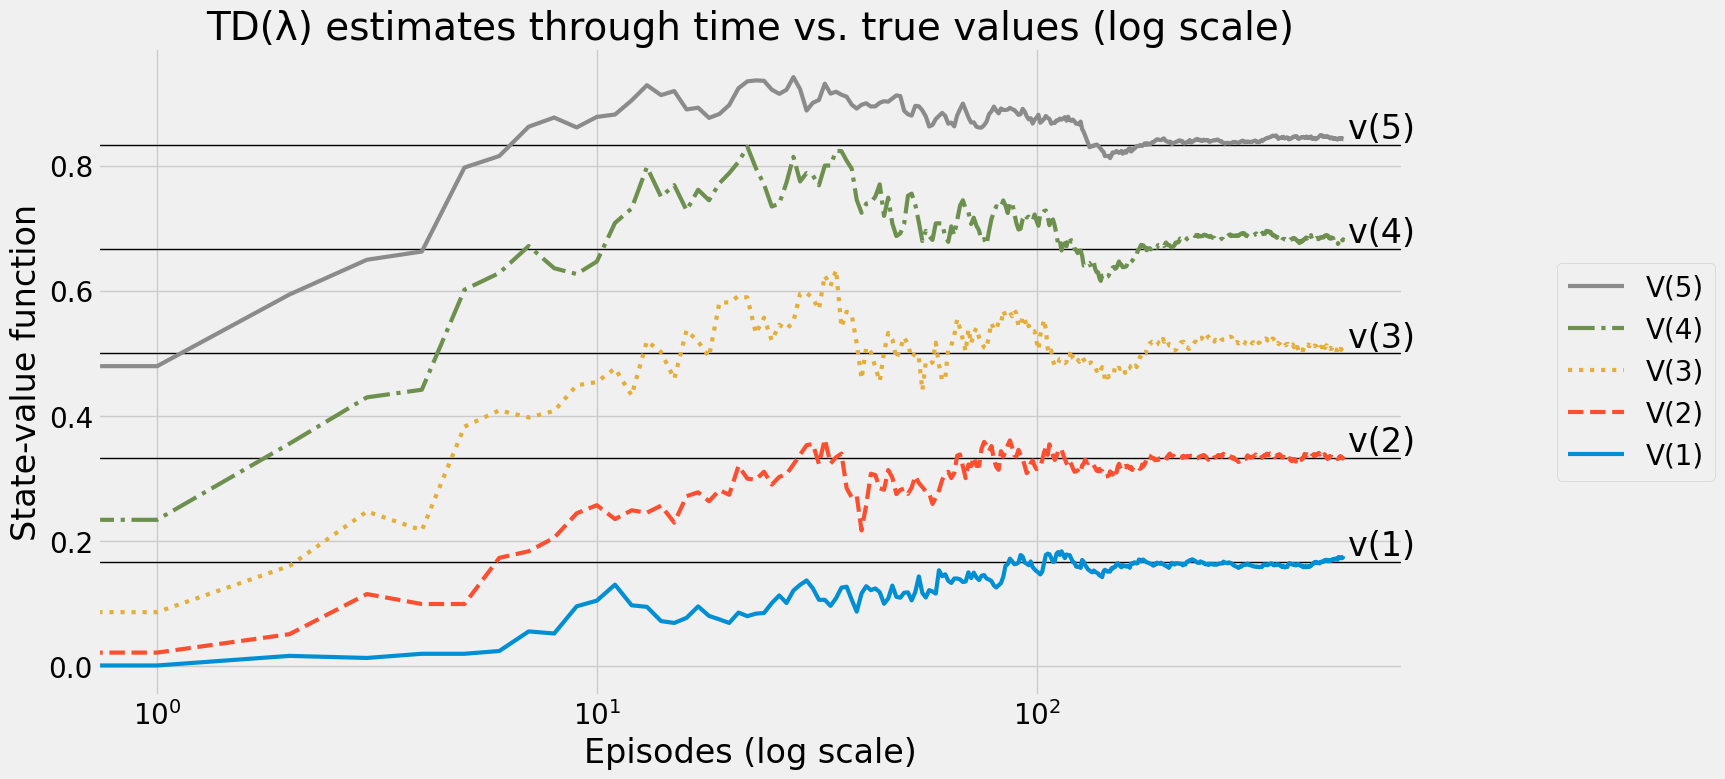

In [20]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)